# Classification model using Random Forest

### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

### 2. Upload Clinic data

In [2]:
path ='../../../Data_preprocessing/Prediction PFS/Clinical_data_categorized_PFS.csv' 
data = pd.read_csv(path)
data.head()

,Unnamed: 0,RNA_ID,Age,Sarc,Rhab,Number_of_Prior_Therapies,Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy,Tumor_Shrinkage,PFS,TM_TC_Ratio,...,MSKCC_NA,MSKCC_POOR,IMDC_FAVORABLE,IMDC_INTERMEDIATE,IMDC_NOT_REPORTED,IMDC_POOR,ImmunoPhenotype_Desert,ImmunoPhenotype_Excluded,ImmunoPhenotype_Infiltrated,ImmunoPhenotype_NA
0,0,NaN,73,0.0,0.0,2.0,808,0.0,1.545205,-1.0,...,0,0,0,0,1,0,0,0,1,0
1,1,NaN,55,0.0,0.0,2.0,1826,0.0,3.419178,-1.0,...,0,0,0,0,1,0,1,0,0,0
2,2,NaN,51,0.0,0.0,1.0,1541,0.0,1.413699,-1.0,...,0,0,0,0,1,0,0,0,1,0
3,3,NaN,70,0.0,0.0,3.0,-1,0.0,0.394521,-1.0,...,0,1,0,0,1,0,0,0,0,1
4,4,NaN,59,0.0,0.0,3.0,376,0.0,10.158904,-1.0,...,0,1,0,0,1,0,0,0,1,0


In [3]:
Y = [] # Target column
# For each entry I classified it by its PFS value.
for i in range (len(data)):
    if data.PFS[i]<3: # If PFS is lower than 3 months, I will consider it as NonResponder (NR)
        Y.append(0)
    elif data.PFS[i]<6: # If PFS is over 6 months, I will consider it as Responder (R)
        Y.append(1)
    else:
        Y.append(2) # If PFS is between 3 and 6 months, I will consider it as SemiResponder (SR)
        
data = data.drop('PFS', axis=1) # As we won't need this column any more, I deleted it.

X = data.iloc[:,2:26] 
# I selected all the columns by removing the Unnamed column (row id) and the Target column.
print(X)
print('Numero de pacientes: ',len(Y))

     Age  Sarc  Rhab  Number_of_Prior_Therapies  \
0     73   0.0   0.0                        2.0   
1     55   0.0   0.0                        2.0   
2     51   0.0   0.0                        1.0   
3     70   0.0   0.0                        3.0   
4     59   0.0   0.0                        3.0   
..   ...   ...   ...                        ...   
285   54   0.0   0.0                        3.0   
286   56   0.0   0.0                        2.0   
287   65   0.0   0.0                        2.0   
288   48   0.0   0.0                        1.0   
289   76   0.0   0.0                        2.0   

     Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy  \
0                                                  808             
1                                                 1826             
2                                                 1541             
3                                                   -1             
4                                              

### 3. Train-Test dataset split

In [4]:
XTrain, XTest, yTrain, yTest = train_test_split(X, Y, test_size=0.20, random_state=125)

print('Training set size:', len(XTrain))
print('Target column size of the training set:', len(yTrain))
print('Test set size:', len(XTest))
print('Target column size of the test set:', len(yTest))

Training set size: 232
Target column size of the training set: 232
Test set size: 58
Target column size of the test set: 58


### 4. Select the parameters of the model and fit it

In [5]:
param_grid = {'min_samples_leaf': [1, 2, 3],
              'min_samples_split': [2, 3, 4, 5],
              'random_state':[125],
              'n_estimators': [10, 20],
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy'],
              'max_depth':[None, 2, 5, 10,50]
              }

# I created a GridSearchCV which allows us to systematically evaluate and select the parameters of our model.
# By indicating a model and the parameters to test, you can evaluate the performance of the first one based on the
# seconds through cross validation.
clf = GridSearchCV(
        estimator  = RandomForestClassifier(),
        param_grid = param_grid,
        cv=5
       )

clf.fit(XTrain , yTrain)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10, 50],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20], 'random_state': [125]})

In [6]:
print("Best estimate of parameters according to GridSearchCV:")
model = clf.best_estimator_
# Fit the model with the best parameters
model.fit(XTrain , yTrain)

Best estimate of parameters according to GridSearchCV:


RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=3,
                       n_estimators=10, random_state=125)

In [7]:
print("Best result of the cross validation of the model with the best paramters:" +str(clf.best_score_))

Best result of the cross validation of the model with the best paramters:0.45744680851063835


### 5. Prediction

In [8]:
# Making predictions with the optimal model on the training dataset
yhatTrain = model.predict(XTrain)
contTrain = 0

# Comparing with the Target column and check how many hits there have been
for i in range(0,len(yTrain),1) :
    if (yhatTrain[i] == yTrain[i]):
        contTrain = contTrain + 1

In [9]:
# Making predictions with the optimal model on the test dataset
yhatTest = model.predict(XTest)
contTest = 0

# Comparing with the Target column and check how many hits there have been
for i in range(0,len(yTest),1) :
    if (yhatTest[i] == yTest[i]):
        contTest = contTest + 1


### 6. Results

In [10]:
print('Final accuracy on the training dataset:' + str(contTrain/len(yTrain)))
print('Final accuracy on the testing dataset: ' + str(contTest/len(yTest)))

Final accuracy on the training dataset:0.5474137931034483
Final accuracy on the testing dataset: 0.4827586206896552


In [11]:
from sklearn.metrics import classification_report,confusion_matrix

print('----------------Confusion Matrix (Training)------------------')
print(confusion_matrix(yTrain,yhatTrain))
print('Input data:  ' + str(np.array(yTrain)))
print('Prediction:        ' +str(yhatTrain))

----------------Confusion Matrix (Training)------------------
[[86  4 15]
 [32 10 12]
 [37  5 31]]
Input data:  [2 0 1 2 0 2 1 2 2 1 1 0 1 0 2 2 2 2 1 2 1 2 1 0 0 2 1 1 0 0 0 2 0 0 1 2 2
 2 0 0 2 0 2 2 0 2 1 2 0 0 2 0 2 0 0 0 0 0 1 0 2 1 2 0 2 0 2 2 2 2 2 2 0 2
 1 2 0 0 0 0 2 0 0 2 2 2 0 0 1 1 1 2 2 1 1 2 0 0 0 0 2 2 1 0 0 0 1 1 2 2 2
 2 0 0 2 0 0 0 0 2 0 1 2 1 2 2 0 1 0 0 0 0 0 0 0 1 0 2 2 1 0 0 0 0 2 2 2 0
 1 1 0 2 0 2 2 2 0 0 0 0 1 1 2 0 2 0 0 1 0 0 0 1 2 0 2 1 2 0 2 0 0 0 1 2 1
 1 0 1 0 1 1 1 0 0 2 1 0 2 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 2 1 1
 0 2 0 0 2 0 1 1 0 0]
Prediction:        [0 0 0 2 0 2 1 0 0 0 2 0 0 0 2 0 2 2 0 2 2 2 1 0 0 0 0 2 2 0 1 2 0 0 0 0 0
 0 1 0 0 0 0 2 1 0 0 2 2 0 0 0 0 0 2 0 0 2 0 0 0 1 0 0 0 0 0 0 0 2 0 0 2 2
 0 0 0 0 0 0 2 0 2 1 0 2 0 0 0 1 0 0 0 1 2 1 2 0 0 0 0 0 0 0 0 0 1 0 1 0 2
 0 0 0 2 0 0 0 0 2 0 2 2 0 2 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 2 2 0 0 0
 0 0 0 2 0 0 0 0 2 0 1 2 0 0 0 0 0 0 0 1 0 0 0 0 2 0 2 0 0 0 2 0 0 0 2 2 0
 2 0 1 2 0 0 0 2 0 2 2

In [12]:
print(classification_report(yTrain,yhatTrain))

              precision    recall  f1-score   support

           0       0.55      0.82      0.66       105
           1       0.53      0.19      0.27        54
           2       0.53      0.42      0.47        73

    accuracy                           0.55       232
   macro avg       0.54      0.48      0.47       232
weighted avg       0.54      0.55      0.51       232



In [13]:
print('----------------Confusion Matrix (Test)------------------')
print(confusion_matrix(yTest,yhatTest))
print('Input data:  ' + str(np.array(yTest)))
print('Prediction:        ' +str(yhatTest))

----------------Confusion Matrix (Test)------------------
[[20  1  4]
 [11  1  3]
 [10  1  7]]
Input data:  [2 2 1 2 0 1 1 2 2 2 0 0 2 0 1 0 0 2 0 2 2 0 2 2 1 0 0 1 1 0 0 2 1 0 0 0 1
 1 1 1 2 2 0 1 0 0 0 0 1 0 2 0 2 1 0 2 0 0]
Prediction:        [2 0 2 0 0 0 1 0 1 2 0 0 0 0 0 0 1 0 0 2 0 0 0 2 0 0 0 0 0 2 0 0 0 2 0 0 0
 2 0 2 2 2 2 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0]


In [14]:
print(classification_report(yTest,yhatTest))

              precision    recall  f1-score   support

           0       0.49      0.80      0.61        25
           1       0.33      0.07      0.11        15
           2       0.50      0.39      0.44        18

    accuracy                           0.48        58
   macro avg       0.44      0.42      0.38        58
weighted avg       0.45      0.48      0.43        58



### 7. Result visualization

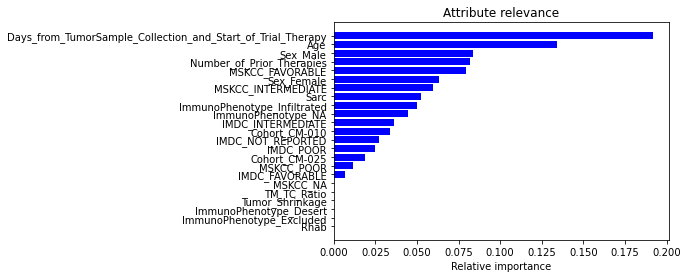

Age = 0.134149287897425
Sarc = 0.05243539789082514
Rhab = 0.0
Number_of_Prior_Therapies = 0.0815713911771096
Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy = 0.19151800477464118
Tumor_Shrinkage = 0.0
TM_TC_Ratio = 0.0
Cohort_CM-010 = 0.033986426125380595
Cohort_CM-025 = 0.018558629199494973
Sex_Female = 0.06332950692251264
Sex_Male = 0.0839206781097865
MSKCC_FAVORABLE = 0.07939667508429717
MSKCC_INTERMEDIATE = 0.059775570603986715
MSKCC_NA = 0.0
MSKCC_POOR = 0.011645757829173967
IMDC_FAVORABLE = 0.006799459762770513
IMDC_INTERMEDIATE = 0.036177104811880016
IMDC_NOT_REPORTED = 0.027120935235904618
IMDC_POOR = 0.0250455508500369
ImmunoPhenotype_Desert = 0.0
ImmunoPhenotype_Excluded = 0.0
ImmunoPhenotype_Infiltrated = 0.04985286025262868
ImmunoPhenotype_NA = 0.04471676347214597


In [15]:
# Through the created model we can see which attributes are the most significant to make a decision.
# The most relevant attributes will be the ones placed at the top of the tree.
features = list(X)
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Attribute relevance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.show()

for name, importance in zip(X, model.feature_importances_):
    print(name, "=", importance)

# Attributes whose relevance is 0, will not be necessary to make the prediction of the target.